# Projeto de Aprendizagem Automática II

## Procura de Exoplanetas no Espaço através da Emissão de Luz de Estrelas

Este *notebook* demonstra o processo de análise exploratória dos dados, bem como a sua preparação para o treino e teste de modelos.

### Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns; sns.set()

from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, classification_report, precision_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import normalize, StandardScaler
from sklearn import linear_model
from imblearn.over_sampling import SMOTE
from scipy import ndimage, fft

%matplotlib inline

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
#!python3 -m pip install imblearn
#conda install -c conda-forge imbalanced-learn 

### Leitura dos Dados em Ficheiro

In [2]:
train_df = pd.read_csv('../../Dados/exoTrain.csv')
test_df = pd.read_csv('../../Dados/exoTest.csv')

Verificação do carregamento dos dados de treino através da apresentação de alguns registos de dados.

In [3]:
train_df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


Verificação do carregamento dos dados de teste através da apresentação de alguns registos de dados.

In [4]:
test_df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84


Analisando a forma dos dados de treino, é possível observar que existem 5087 observações, tendo cada uma 3198 valores de intensidade luminosa.

In [5]:
train_df.shape

(5087, 3198)

No que toca às *labels* dos dados de treino, mais de 99% dos dados são sistemas sem exoplanetas e apenas 0.7% são referentes a sistemas com um ou mais exoplanetas.

In [6]:
train_df.LABEL.value_counts(normalize=True)

1    0.992727
2    0.007273
Name: LABEL, dtype: float64

Já para os dados de teste, as percentagens são semelhantes, existindo um aumento de 0.1% de sistemas com exoplanetas.

In [7]:
test_df.LABEL.value_counts(normalize=True)

1    0.991228
2    0.008772
Name: LABEL, dtype: float64

### Visualização dos Dados

De modo a observar graficamente as séries temporais, é crucial separar as *labels* dos respetivos valores de intensidade, como se pode observar em seguida.

In [28]:
X_train = train_df.loc[:, train_df.columns != 'LABEL'].values
y_train = train_df.LABEL.values

X_test = test_df.loc[:, test_df.columns != 'LABEL'].values
y_test = test_df.LABEL.values

Tendo os valores de intensidade separados das suas *labels*, a representação gráfica torna-se mais simples. Assim, de modo a confirmar a existência de diferenças e na forma de classificação dos sistemas, devem ser visualizados sistemas com e sem exoplanetas, permitindo a sua comparação.

Pela análise das *labels* dos dados de treino, é possível observar que os 3 primeiros registos tratam-se de sistemas com exoplanetas, contrariamente aos 3 últimos. Desta forma, serão utilizados para a representação gráfica como mencionado anteriormente.

In [9]:
y_train

array([2, 2, 2, ..., 1, 1, 1])

Desta forma, em seguida, têm-se as três estrelas com exoplanetas confirmados para representação gráfica.

##### Sistema Número 0

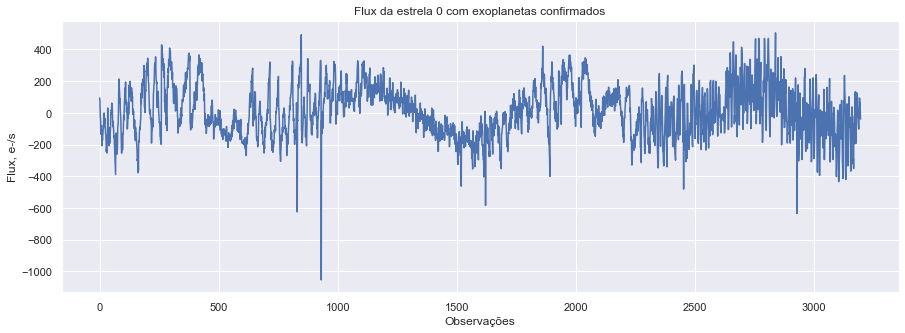

In [10]:
flux = train_df.drop('LABEL', axis=1).iloc[0,:]
time = np.arange(len(flux)) # time in units of hours
plt.figure(figsize=(15,5))
plt.title('Flux da estrela 0 com exoplanetas confirmados')
plt.ylabel('Flux, e-/s')
plt.xlabel('Observações')
plt.plot(time, flux)

##### Sistema Número 1

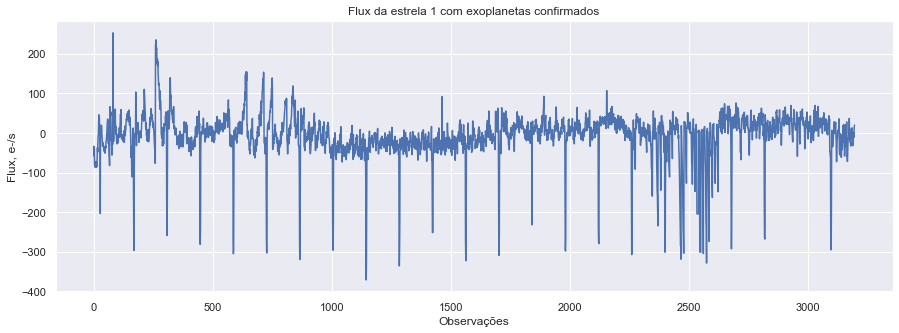

In [11]:
flux = train_df.drop('LABEL', axis=1).iloc[1,:]
time = np.arange(len(flux))
plt.figure(figsize=(15,5))
plt.title('Flux da estrela 1 com exoplanetas confirmados')
plt.ylabel('Flux, e-/s')
plt.xlabel('Observações')
plt.plot(time, flux)

##### Sistema Número 2

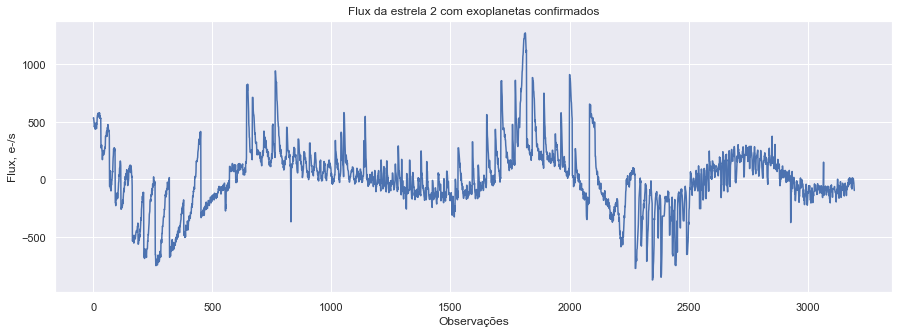

In [12]:
flux = train_df.drop('LABEL', axis=1).iloc[2,:]
time = np.arange(len(flux)) 
plt.figure(figsize=(15,5))
plt.title('Flux da estrela 2 com exoplanetas confirmados')
plt.ylabel('Flux, e-/s')
plt.xlabel('Observações')
plt.plot(time, flux)

No que toca aos sistemas sem exoplanetas, tenham-se os seguintes:

##### Sistema Número 5084

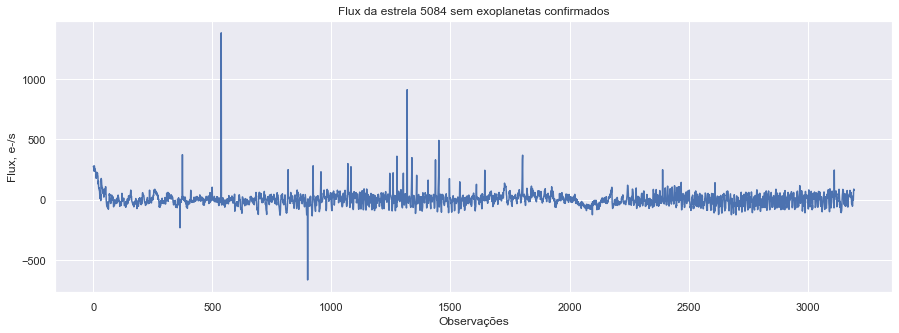

In [13]:
flux = train_df.drop('LABEL', axis=1).iloc[5084,:]
time = np.arange(len(flux)) 
plt.figure(figsize=(15,5))
plt.title('Flux da estrela 5084 sem exoplanetas confirmados')
plt.ylabel('Flux, e-/s')
plt.xlabel('Observações')
plt.plot(time, flux)

##### Sistema Número 5085

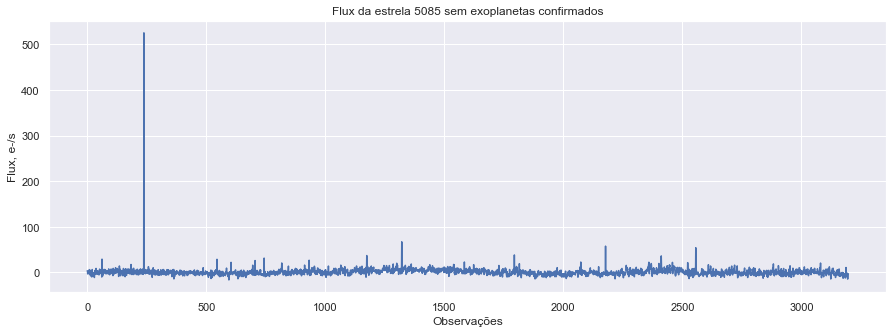

In [14]:
flux = train_df.drop('LABEL', axis=1).iloc[5085,:]
time = np.arange(len(flux))
plt.figure(figsize=(15,5))
plt.title('Flux da estrela 5085 sem exoplanetas confirmados')
plt.ylabel('Flux, e-/s')
plt.xlabel('Observações')
plt.plot(time, flux)

##### Sistema Número 5086

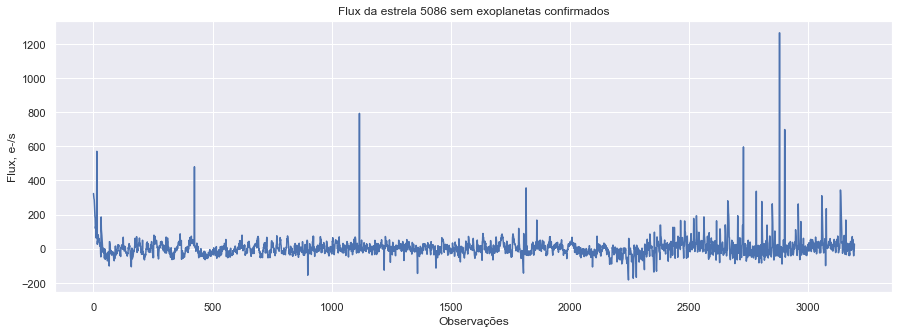

In [15]:
flux = train_df.drop('LABEL', axis=1).iloc[5086,:]
time = np.arange(len(flux))
plt.figure(figsize=(15,5))
plt.title('Flux da estrela 5086 sem exoplanetas confirmados')
plt.ylabel('Flux, e-/s')
plt.xlabel('Observações')
plt.plot(time, flux)

### Normalização dos Dados

De modo a permitir que os modelos possam convergir o mais rapidamente possível e haja uma diminuição do peso computacional, os dados devem ser normalizados.

A primeira ideia passa por normalizar os valores dentro do intervalo [-1, 1], sendo utilizada classe *Normalizer*.

In [4]:
from sklearn.preprocessing import Normalizer
ss = Normalizer()

X_train = ss.fit_transform(X_train.T).T
X_test = ss.fit_transform(X_test.T).T

Em seguida, tendo em conta a grande diferença nas *labels*, devem ser gerados dados no seguimento de *data augmentation*. Desta forma, foi definido que seria proveitoso existir 30% da classe minoritária para 70% da outra classe, mantendo-se uma classe predominante relativamente à outra. 

In [5]:
from imblearn.over_sampling import SMOTE
model_smote = SMOTE(sampling_strategy=0.3)
X_train, y_train = model_smote.fit_sample(X_train, y_train)

### Teste 

De modo a confirmar a qualidade do processamento efetuado, estes devem ser usados para treinar um modelo simples. Consoante as métricas deste modelo, será possível ter uma ideia se é necessário mais processamento dos dados ou uma maior complexidade dos modelos permite alcançar bons resultados. 

In [6]:
model = linear_model.SGDClassifier(max_iter=1000, loss="perceptron", penalty="l2", alpha=1e-2, eta0=1.0, learning_rate="invscaling")
model.fit(X_train, y_train)

SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=1.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='invscaling', loss='perceptron',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Como se estão a analisar dados com elevada diferença na percentagem de existência de cada classe, não se pode analisar apenas a *accuracy* dos modelos. Como se pode observar em seguida, esta é bastante alta, sendo previamente expectável. 

In [7]:
Y_train_predicted = model.predict(X_train)
Y_test_predicted =  model.predict(X_test)

print("Train accuracy = %.4f" % accuracy_score(y_train, Y_train_predicted))
print("Test accuracy = %.4f" % accuracy_score(y_test, Y_test_predicted))

Train accuracy = 0.7919
Test accuracy = 0.8140


Analisando as matrizes de confusão é possível ter uma visão mais concreta da existência de *overfitting*. Assim, é notório que o modelo gerado conseguiu classificar corretamente um sistema da classe minoritária de 5 possíveis. Outro exemplo de que os dados precisam de mais tratamento é a classificação errada de vários registos dos dados de treino.

In [8]:
confusion_matrix_train = confusion_matrix(y_train, Y_train_predicted)
confusion_matrix_test = confusion_matrix(y_test, Y_test_predicted)
classification_report_train = classification_report(y_train, Y_train_predicted)
classification_report_test = classification_report(y_test, Y_test_predicted)

print("Confusion Matrix (train sample):\n", confusion_matrix_train)
print("Confusion Matrix (test sample):\n", confusion_matrix_test)
print("\n")
print("Classification_report (train sample):\n", classification_report_train)
print("Classification_report (test sample):\n", classification_report_test)

Confusion Matrix (train sample):
 [[4803  247]
 [1119  396]]
Confusion Matrix (test sample):
 [[463 102]
 [  4   1]]


Classification_report (train sample):
               precision    recall  f1-score   support

           1       0.81      0.95      0.88      5050
           2       0.62      0.26      0.37      1515

    accuracy                           0.79      6565
   macro avg       0.71      0.61      0.62      6565
weighted avg       0.77      0.79      0.76      6565

Classification_report (test sample):
               precision    recall  f1-score   support

           1       0.99      0.82      0.90       565
           2       0.01      0.20      0.02         5

    accuracy                           0.81       570
   macro avg       0.50      0.51      0.46       570
weighted avg       0.98      0.81      0.89       570



Como nem sempre a normalização é o melhor método quando se estão a processar dados temporais, deve ser tentado o mesmo método aplicando *standardization*. A diferença é que na normalização pode ocorrer a perda de *outliers*, algo que pode ser proveitoso analisar no contexto do problema.

In [10]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X_train = ss.fit_transform(X_train.T).T
X_test = ss.fit_transform(X_test.T).T

Mais uma vez deve ser tratado o desbalanceamento dos dados.

In [11]:
from imblearn.over_sampling import SMOTE
model_smote = SMOTE(sampling_strategy=0.3)
X_train, y_train = model_smote.fit_sample(X_train, y_train)

E, por fim, testado o mesmo modelo para efeitos de comparação.

In [25]:
model = linear_model.SGDClassifier(max_iter=1000, loss="perceptron", penalty="l2", alpha=1e-2, eta0=1.0, learning_rate="invscaling")
model.fit(X_train, y_train)

SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=1.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='invscaling', loss='perceptron',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Pelos valores da *accuracy*, é possível observar que apesar do *overfitting*, este modelo é menos errático que o anterior, ou seja, classifica corretamente um maior número de registos.

In [26]:
Y_train_predicted = model.predict(X_train)
Y_test_predicted =  model.predict(X_test)

print("Train accuracy = %.4f" % accuracy_score(y_train, Y_train_predicted))
print("Test accuracy = %.4f" % accuracy_score(y_test, Y_test_predicted))

Train accuracy = 0.9925
Test accuracy = 0.9842


Apesar do *overfitting*, é possível observar que para os dados de teste foram classificados 4 registos como sendo da classe minoritária. APesar de serem classificações erradas, pedem um maior processamento dos dados de modo a melhorar o modelo.

In [27]:
confusion_matrix_train = confusion_matrix(y_train, Y_train_predicted)
confusion_matrix_test = confusion_matrix(y_test, Y_test_predicted)
classification_report_train = classification_report(y_train, Y_train_predicted)
classification_report_test = classification_report(y_test, Y_test_predicted)

print("Confusion Matrix (train sample):\n", confusion_matrix_train)
print("Confusion Matrix (test sample):\n", confusion_matrix_test)
print("\n")
print("Classification_report (train sample):\n", classification_report_train)
print("Classification_report (test sample):\n", classification_report_test)

Confusion Matrix (train sample):
 [[5030   20]
 [  29 1486]]
Confusion Matrix (test sample):
 [[561   4]
 [  5   0]]


Classification_report (train sample):
               precision    recall  f1-score   support

           1       0.99      1.00      1.00      5050
           2       0.99      0.98      0.98      1515

    accuracy                           0.99      6565
   macro avg       0.99      0.99      0.99      6565
weighted avg       0.99      0.99      0.99      6565

Classification_report (test sample):
               precision    recall  f1-score   support

           1       0.99      0.99      0.99       565
           2       0.00      0.00      0.00         5

    accuracy                           0.98       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.98      0.98       570



Outro método que vale a pena testar é a análise dos dados no espaço das frequências, ou seja, observando as séries temporais como um sinal, pode ser calculada a sua Transformada de Fourier. Este método é um método bastante utilizado e que pode permitir uma maior diferenciação entre as classes.

In [29]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X_train = ss.fit_transform(X_train.T).T
X_test = ss.fit_transform(X_test.T).T

Assumindo que a análise no espaço da frequência permite melhores resultados, o processo de *data augmentation* será efetuado após o cálculo das mesmas.

In [30]:
from scipy.fftpack import fft, fftshift, fftfreq
X_train = np.abs(fft(X_train))
X_test = np.abs(fft(X_test))
freq_range = fftshift(fftfreq(X_train.shape[1]))

De modo a confirmar a maior diferenciação entre os novos dados, serão apresentados graficamente alguns registos.

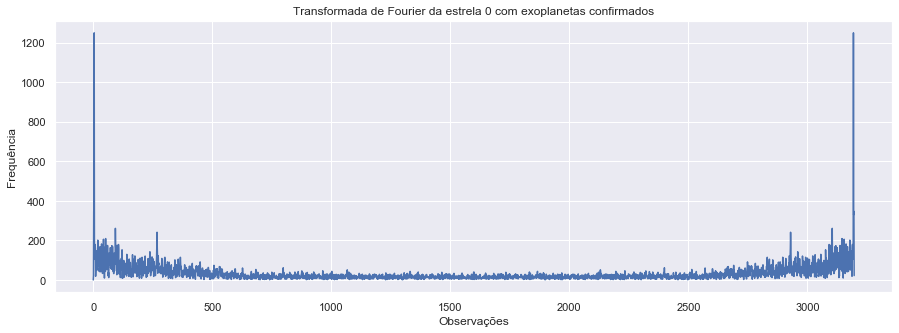

In [31]:
flux = X_train[0,:]
time = np.arange(len(flux)) 
plt.figure(figsize=(15,5))
plt.title('Transformada de Fourier da estrela 0 com exoplanetas confirmados')
plt.ylabel('Frequência')
plt.xlabel('Observações')
plt.plot(time, flux)

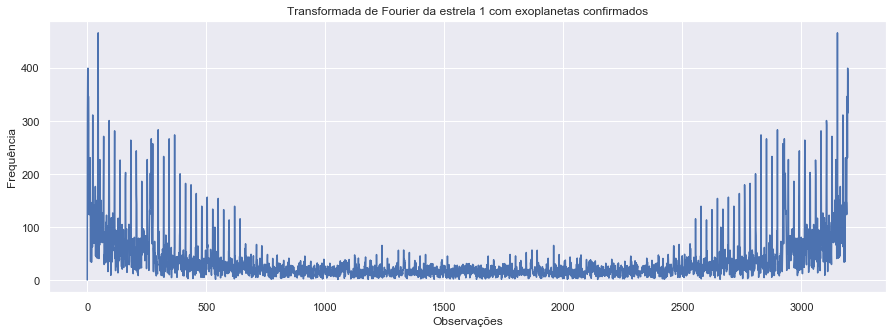

In [32]:
flux = X_train[1,:]
time = np.arange(len(flux)) 
plt.figure(figsize=(15,5))
plt.title('Transformada de Fourier da estrela 1 com exoplanetas confirmados')
plt.ylabel('Frequência')
plt.xlabel('Observações')
plt.plot(time, flux)

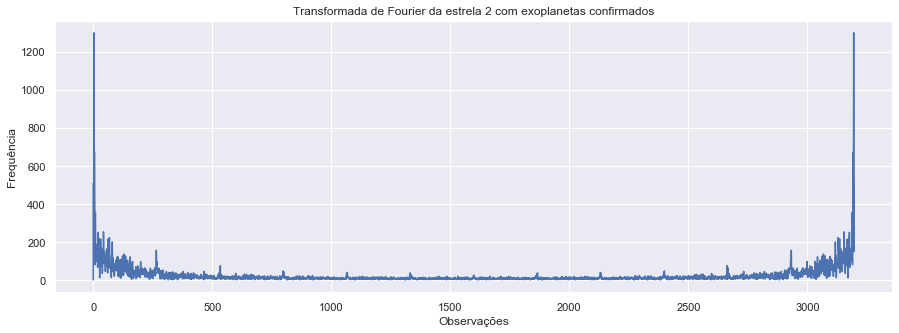

In [33]:
flux = X_train[2,:]
time = np.arange(len(flux)) 
plt.figure(figsize=(15,5))
plt.title('Transformada de Fourier da estrela 2 com exoplanetas confirmados')
plt.ylabel('Frequência')
plt.xlabel('Observações')
plt.plot(time, flux)

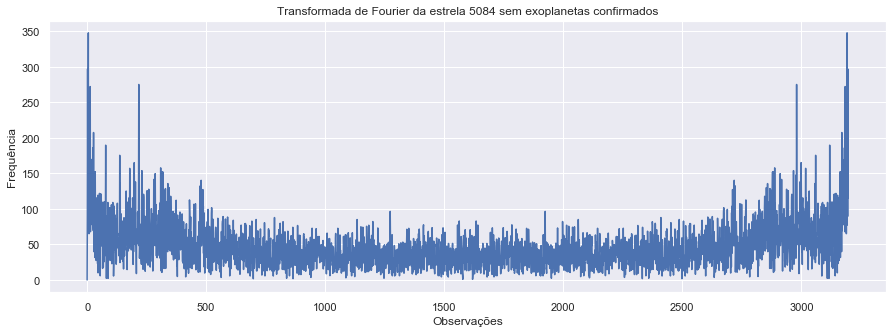

In [34]:
flux = X_train[5084,:]
time = np.arange(len(flux)) 
plt.figure(figsize=(15,5))
plt.title('Transformada de Fourier da estrela 5084 sem exoplanetas confirmados')
plt.ylabel('Frequência')
plt.xlabel('Observações')
plt.plot(time, flux)

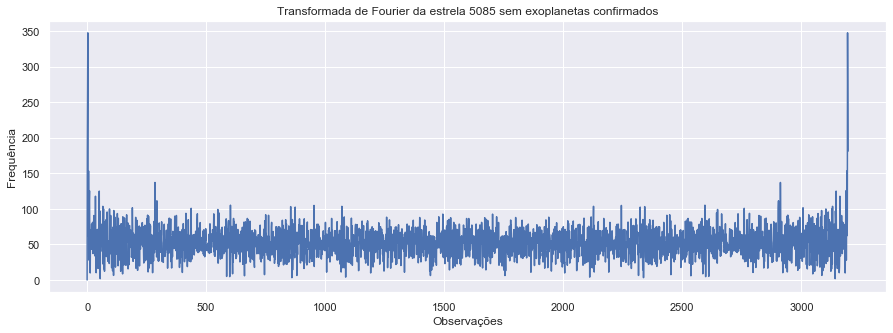

In [35]:
flux = X_train[5085,:]
time = np.arange(len(flux)) 
plt.figure(figsize=(15,5))
plt.title('Transformada de Fourier da estrela 5085 sem exoplanetas confirmados')
plt.ylabel('Frequência')
plt.xlabel('Observações')
plt.plot(time, flux)

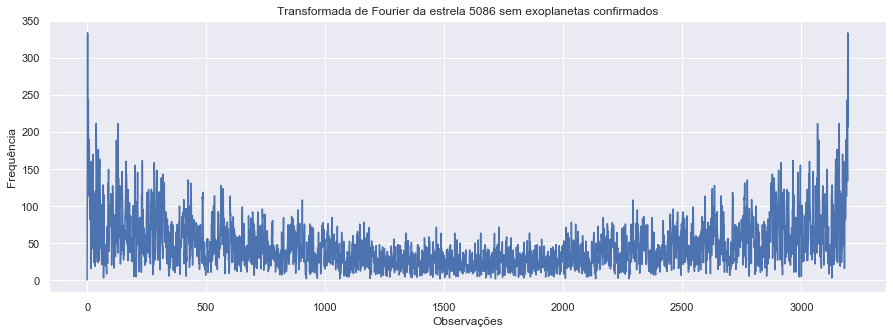

In [36]:
flux = X_train[5086,:]
time = np.arange(len(flux)) 
plt.figure(figsize=(15,5))
plt.title('Transformada de Fourier da estrela 5086 sem exoplanetas confirmados')
plt.ylabel('Frequência')
plt.xlabel('Observações')
plt.plot(time, flux)

### Data Augmentation

Ora, como os resultados parecem promissores, deve ser efetuado o processo de *data augmentation*, numa tentativa de diminuição do *overfitting* nos modelos.

In [37]:
from imblearn.over_sampling import SMOTE
model_smote = SMOTE(sampling_strategy=0.3)
X_train, y_train = model_smote.fit_sample(X_train, y_train)

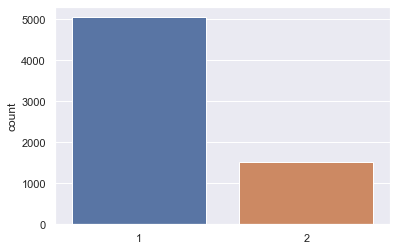

In [38]:
sns.countplot(y_train)

### Teste

Mais uma vez, de modo a validar o processamento, os dados devem ser testados no modelo previamente utilizado.

In [45]:
model = linear_model.SGDClassifier(max_iter=1000, loss="perceptron", penalty="l2", alpha=1e-2, eta0=1.0, learning_rate="invscaling")
model.fit(X_train, y_train)

SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=1.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='invscaling', loss='perceptron',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Pelos valores de *accuracy* não é possível concluir se a análise no espaço das frequências teve alterações suficientemente notórias. Assim, é necessário analisar as restantes métricas.

In [46]:
Y_train_predicted = model.predict(X_train)
Y_test_predicted =  model.predict(X_test)

print("Train accuracy = %.4f" % accuracy_score(y_train, Y_train_predicted))
print("Test accuracy = %.4f" % accuracy_score(y_test, Y_test_predicted))

Train accuracy = 0.9936
Test accuracy = 0.9912


Apenas pela comparação das *labels* no conjunto de treino, é visível que este conjunto de dados parece mais promissor do que os anteriores.

In [47]:
print(y_test)
print(Y_test_predicted)

[2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

Observando as matrizes de confusão torna-se notória a maior qualidade destes dados. Assim, este será o *dataset* a utilizar nos modelos gerados, pois pode permitir os melhores resultados devido à maior diferenciação entre classes.

In [48]:
confusion_matrix_train = confusion_matrix(y_train, Y_train_predicted)
confusion_matrix_test = confusion_matrix(y_test, Y_test_predicted)
classification_report_train = classification_report(y_train, Y_train_predicted)
classification_report_test = classification_report(y_test, Y_test_predicted)

print("Confusion Matrix (train sample):\n", confusion_matrix_train)
print("Confusion Matrix (test sample):\n", confusion_matrix_test)
print("\n")
print("Classification_report (train sample):\n", classification_report_train)
print("Classification_report (test sample):\n", classification_report_test)

Confusion Matrix (train sample):
 [[5035   15]
 [  27 1488]]
Confusion Matrix (test sample):
 [[562   3]
 [  2   3]]


Classification_report (train sample):
               precision    recall  f1-score   support

           1       0.99      1.00      1.00      5050
           2       0.99      0.98      0.99      1515

    accuracy                           0.99      6565
   macro avg       0.99      0.99      0.99      6565
weighted avg       0.99      0.99      0.99      6565

Classification_report (test sample):
               precision    recall  f1-score   support

           1       1.00      0.99      1.00       565
           2       0.50      0.60      0.55         5

    accuracy                           0.99       570
   macro avg       0.75      0.80      0.77       570
weighted avg       0.99      0.99      0.99       570



### Armazenamento dos Dados em Ficheiro

De modo a serem exatamente os mesmos dados a ser comparados, estes devem ser guardados em ficheiro, permitindo a sua leitura rápida.

#### Dados de Treino

In [49]:
treino = {'LABEL' : y_train}
for i in range(0,X_train.shape[1]):
    treino['FLUX.' + str(i)] = X_train[:,i]

df = pd.DataFrame(data = treino)
df.to_csv('../../Dados/dados_treino.csv', sep=',', encoding='utf-8')

#### Dados de Teste

In [50]:
teste = {'LABEL' : y_test}
for i in range(0,X_test.shape[1]):
    teste['FLUX.' + str(i)] = X_test[:,i]

df_test = pd.DataFrame(data = teste)
df_test.to_csv('../../Dados/dados_teste.csv', sep=',', encoding='utf-8')